<h1><center>COVID-19. Детекция Атипичной пневмонии по рентгеновским снимкам</center></h1>

<center><img src = "https://ichef.bbci.co.uk/news/800/cpsprodpb/1EA6/production/_110764870_coronavirusmedium.jpg.webp" width = "750" height = "500"/></center>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>[Трнировка Модели]</center></h2>

### Ссылки

[Detectron_offical](https://github.com/facebookresearch/detectron2)

[VinBigData detectron2](https://www.kaggle.com/corochann/vinbigdata-detectron2-train)

[Detectron2 Tutorial](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=QHnVupBBn9eR)

[Albumentastions in detectron2](https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data)

В качестве фреймворка я выбрал Detectron2 по ряду причин:

    - Субъективно нравится
    - Понятный мануал
    - Неплохие результаты ( пробовал его в соревновании на Кагле)
    - Возможность гибкой настройки обучения

**DETECTRON2**

Detectron2 - это система нового поколения от Facebook AI Research, реализующая самые современные алгоритмы обнаружения объектов.

# Импорт Библиотек

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
import logging
import pickle
from pathlib import Path
from typing import Optional

import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings

import config
from COVID19_dict import build_COVID19_data_dicts

In [2]:
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

# Загрузка данных

In [4]:
imdir = f'{config.DATA_ROOT_RESIZED}/img_sz_640'
# Загрузим CSV полученный в ноутбуке с EDA
train_df = pd.read_csv(f'{config.DATA_ROOT}/train_image_df.csv')
print(f'Number of studies: {len(train_df)}')

Number of studies: 6334


## Configs

In [5]:
classes = [
    "atypical",
    "indeterminate",
    "negative",
    "typical"
]

debug=False
split_mode="valid20" # Or  "all_train"

category_name_to_id = {
    class_name: index for index, class_name in enumerate(classes)
}

print(category_name_to_id)

{'atypical': 0, 'indeterminate': 1, 'negative': 2, 'typical': 3}


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>[Подготовка данных]</center></h2>

Для определения кстомного датасета, нам нужно создать **список словарей** (dataset_dicts) где каждый словарь содержит:

 - file_name: имя файла изображения
 - image_id: id изображения, (он же индекс).
 - height: высота изображения.
 - width: Ширина изображения.
 - annotation: основные аннотационные данные для обнаружения объектов, которые содержат следующее:
   - bbox: bounding box pixel location имеющий shape n_boxes,4
   - bbox_mode: Тут тспользуется BoxMode.XYXY_ABS. Абсолютное значение (x_min, y_min, x_max, y_max) аннотаций используется в bbox
   - category_id: class label id for each bounding box, with shape (n_boxes,)


*build_COVID19_data_dicts* для подготовки тренировочных даных
*build_COVID19_data_dicts* c аргументом *test* для подготовки тестовых даных

Этот *dataset_dicts* содержит метаданные для фактических данных, передаваемых в нейронную сеть.
Он загружается перед обучением в памяти, поэтому он должен содержать все метаданные (путь к файлу изображения и т. д.) для создания набора обучающих данных, но не должен содержать **тяжелые данные**. 

На практике загрузка всех связанных массивов изображений слишком велика для загрузки в память, поэтому они загружаются внутри DataLoader по требованию (Это делается при помощи класса *mapper в detectron2*

In [6]:
if split_mode == "all_train":
    print("selected split mode is ALL_TRAIN")
    DatasetCatalog.register(
        "COVID19_data_train",
        lambda: get_COVID19_data_dicts(
            imgdir,
            train_df,
            debug=debug,
            data_type="train",
            cache_mode='All'
        ),
    )
    MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
    
    
    dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
    metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")
    
elif split_mode == 'valid20':
    print("selected split mode is valid20'")
    n_dataset = len(
        build_COVID19_data_dicts(
            imdir,
            train_df,
            debug=debug,
            data_type = 'train',
            cache_mode='All'
        )
    )
    n_train = int(n_dataset * 0.90)
    print(f'All_dataset_size: {n_dataset}, train_dataset_size: {n_train}')
    rs = np.random.RandomState(42)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    # Регестрируем тренировочный датасет
    DatasetCatalog.register(
        "COVID19_data_train",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            target_indices=train_inds,
            debug=debug,
            data_type="train",
            cache_mode='train'
        ),
    )
    MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
    # Регестрируем валидационный датасет
    DatasetCatalog.register(
        "COVID19_data_valid",
        lambda: build_COVID19_data_dicts(
            imdir,
            train_df,
            target_indices=train_inds,
            debug=debug,
            data_type="train",
            cache_mode='val'
        ),
    )
    MetadataCatalog.get("COVID19_data_valid").set(thing_classes=classes)
    
    dataset_dicts_train = DatasetCatalog.get("COVID19_data_train")
    metadata_dicts_train = MetadataCatalog.get("COVID19_data_train")
    
    dataset_dicts_valid = DatasetCatalog.get("COVID19_data_valid")
    metadata_dicts_valid = MetadataCatalog.get("COVID19_data_valid")
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

selected split mode is valid20'
Load from cache dataset_dicts_cache_All.pkl
All_dataset_size: 6334, train_dataset_size: 5700
Load from cache dataset_dicts_cache_train.pkl
Load from cache dataset_dicts_cache_val.pkl


# Визуализация данных

Detectron2 в своем арсенале имеет инструменты по визуализации. Это упрощает нам жизнь. Для получения таких же изображений в ноутбуке  Анализа данных была написана не одна громоздкая функция и не одна клавиатура была сломана 😂. 

В детектроне же есть класс Visualizer

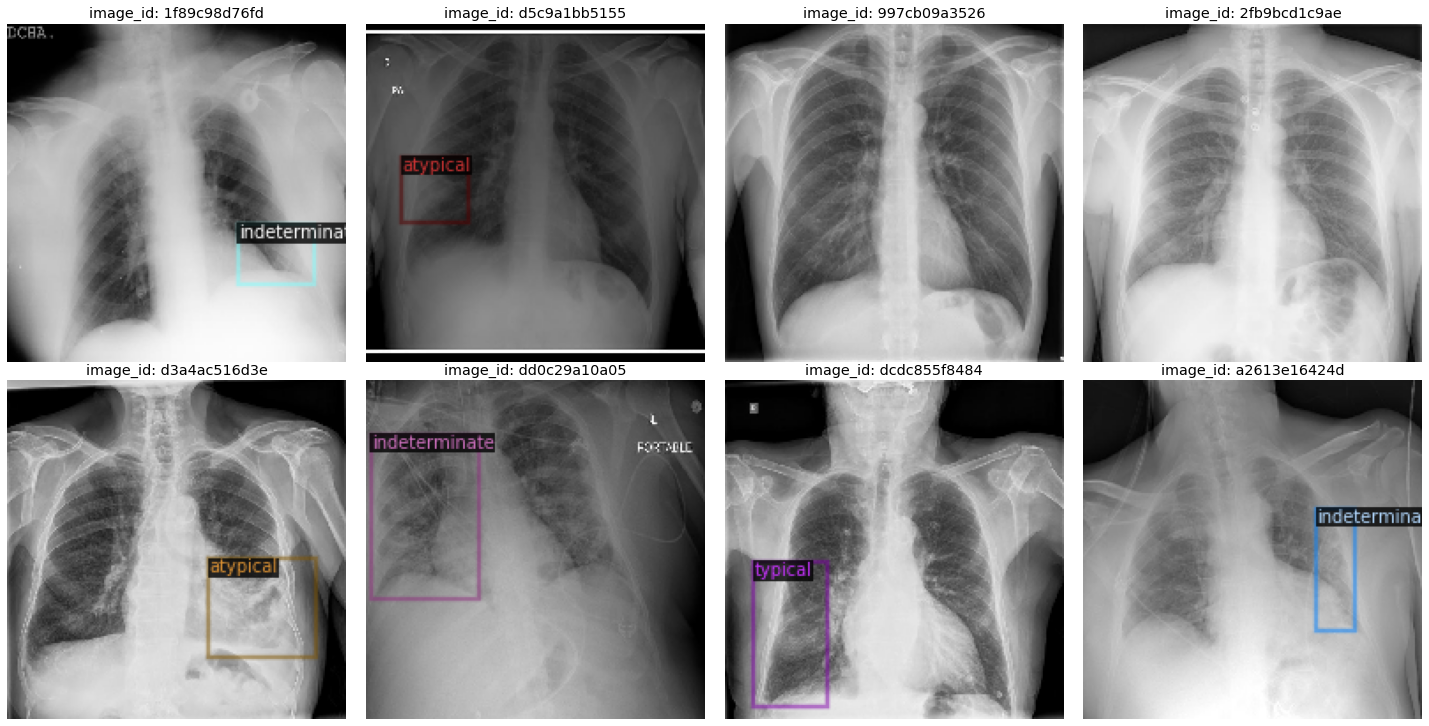

In [7]:
fig, ax = plt.subplots(2, 4, figsize =(20,10))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3]]
i=-1
for d in random.sample(dataset_dicts_train, 8):
    i+=1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts_train, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].set_title(f'image_id: {d["image_id"]}')
    indices[i].imshow(out.get_image()[:, :, ::-1])
plt.tight_layout(pad=0.5)

# DATALOADER

Detectron2 содержит в себе 2 встроенных пайплайна загрузки данных. build_detection_{train,test}_loader
 - [ref : detectron2 docs "Dataloader"](https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html)


Класс Mapper используется внутри DataLoader. Он отвечает за преобразование dataset_dicts в фактические данные, передаваемые в нейронную сеть, и мы можем вставить аугментации в этот класс Mapper.

Другими словами - грузим из зарегестрированного датасета спсиок словарей, обрабатываем мапером, который может включать в себя аугментации и подаем с сетку

Напишем два кастомных мапера. Один использует аугментации, реализованные в Detectron2, а второй AlbumentationsMapper, который использует аугментации библиотеки Albumentations.

In [22]:
"""
Referenced:
 - https://detectron2.readthedocs.io/en/latest/tutorials/data_loading.html
 - https://www.kaggle.com/dhiiyaur/detectron-2-compare-models-augmentation/#data
"""

class MyMapper:
    '''
    Mapper which uses 'detectron2.data.transform' augmentations
    '''

    def __init__(self, cfg, is_train: bool = True):
        '''
        :param cfg: detectron2 configuration
        :param is_train: True if train
        '''
        #aug_kwargs = cfg.aug_kwargs
        aug_list = [
            T.Resize((640, 640)),
            T.RandomBrightness(0.8, 1.2),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
        ]
        # if is_train:
        #     aug_list.extend([getattr(T, name)(**kwargs) for name, kwargs in aug_kwargs.items()])
        self.augmentations = T.AugmentationList(aug_list)
        self.is_train = is_train
        mode = "training" if is_train else "inference"
        print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")

        aug_input = T.AugInput(image)
        transforms = self.augmentations(aug_input)
        image = aug_input.image

        image_shape = image.shape[:2]  # h, w
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        annos = [
            utils.transform_instance_annotations(obj, transforms, image_shape)
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [23]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=MyMapper(cfg, True), sampler=sampler
        )

In [27]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = ("COVID19_data_train",)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = ("COVID19_data_valid",)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url(config_name)
#cfg.MODEL.WEIGHTS="/home/paul/Github/MFTI_CV/Final Project/output/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 5000 #adjust up if val mAP is still rising, adjust down if overfit

cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#Training using custom trainer defined above
trainer = MyTrainer(cfg)
#trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/11 22:15:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:26, 6.21MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.bo

[01/11 22:16:09 d2.engine.train_loop]: Starting training from iteration 0
[01/11 22:16:12 d2.utils.events]:  eta: 0:13:30  iter: 19  total_loss: 1.957  loss_cls: 0.9982  loss_box_reg: 0.5861  loss_rpn_cls: 0.07813  loss_rpn_loc: 0.01303  time: 0.1630  data_time: 0.0188  lr: 0.00039962  max_mem: 1678M
[01/11 22:16:16 d2.utils.events]:  eta: 0:13:26  iter: 39  total_loss: 1.257  loss_cls: 0.487  loss_box_reg: 0.6025  loss_rpn_cls: 0.05331  loss_rpn_loc: 0.007881  time: 0.1653  data_time: 0.0205  lr: 0.00079922  max_mem: 1678M
[01/11 22:16:19 d2.utils.events]:  eta: 0:13:18  iter: 59  total_loss: 1.321  loss_cls: 0.4515  loss_box_reg: 0.8474  loss_rpn_cls: 0.0328  loss_rpn_loc: 0.007572  time: 0.1642  data_time: 0.0186  lr: 0.0011988  max_mem: 1678M
[01/11 22:16:22 d2.engine.hooks]: Overall training speed: 75 iterations in 0:00:12 (0.1712 s / it)
[01/11 22:16:22 d2.engine.hooks]: Total training time: 0:00:12 (0:00:00 on hooks)
[01/11 22:16:22 d2.utils.events]:  eta: 0:13:21  iter: 77  tot

KeyboardInterrupt: 

In [28]:
covid_meta = MetadataCatalog.get("COVID19_data_train").set(thing_classes=classes)
outdir = Path('/home/paul/Github/MFTI_CV/Final Project/output/model_final.pth')

In [29]:
outdir

PosixPath('/home/paul/Github/MFTI_CV/Final Project/output/model_final.pth')

[MyDatasetMapper] Augmentations used in training: AugmentationList[Resize(shape=(640, 640)), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5, horizontal=False, vertical=True), RandomFlip(prob=0.5)]
Load from cache dataset_dicts_cache_train.pkl
[01/11 22:17:35 d2.data.build]: Removed 1551 images with no usable annotations. 4149 images left.
[01/11 22:17:35 d2.data.common]: Serializing 4149 elements to byte tensors and concatenating them all ...
[01/11 22:17:35 d2.data.common]: Serialized dataset takes 1.14 MiB
Visualization img (640, 640, 3) saved in /home/paul/Github/MFTI_CV/Final Project/output/model_final.pth/vinbigdata_0_aug0.jpg
Visualization img (640, 640, 3) saved in /home/paul/Github/MFTI_CV/Final Project/output/model_final.pth/vinbigdata_1_aug0.jpg
[MyDatasetMapper] Augmentations used in training: AugmentationList[Resize(shape=(640, 640)), RandomBrightness(intensity_min=0.8, intensity_max=1.2), RandomFlip(prob=0.5, horizontal=False, vertical=True), R

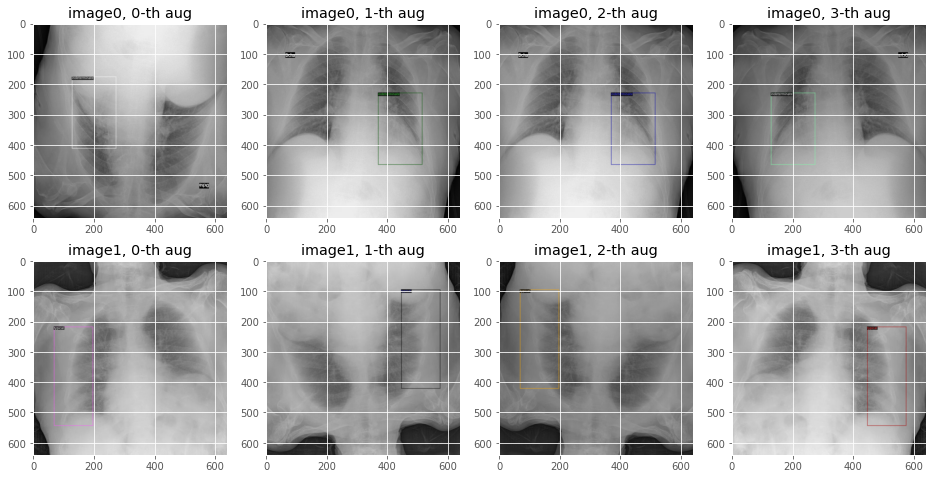

In [30]:
# Visualize data...
# import matplotlib.pyplot as plt
from detectron2.data.samplers import TrainingSampler

n_images = 2
n_aug = 4

fig, axes = plt.subplots(n_images, n_aug, figsize=(16, 8))

# Ref https://github.com/facebookresearch/detectron2/blob/22b70a8078eb09da38d0fefa130d0f537562bebc/tools/visualize_data.py#L79-L88
for i in range(n_aug):
    sampler = TrainingSampler(len(dataset_dicts_train), shuffle=False)
    train_vis_loader = MyTrainer.build_train_loader(
        cfg, sampler=sampler
    )  # For visualization...
    for batch in train_vis_loader:
        for j, per_image in enumerate(batch):
            ax = axes[j, i]

            img_arr = per_image["image"].cpu().numpy().transpose((1, 2, 0))
            visualizer = Visualizer(
                img_arr[:, :, ::-1], metadata=covid_meta, scale=1.0
            )
            target_fields = per_image["instances"].get_fields()
            labels = [
                covid_meta.thing_classes[i] for i in target_fields["gt_classes"]
            ]
            out = visualizer.overlay_instances(
                labels=labels,
                boxes=target_fields.get("gt_boxes", None),
                masks=target_fields.get("gt_masks", None),
                keypoints=target_fields.get("gt_keypoints", None),
            )
            # out = visualizer.draw_dataset_dict(per_image)

            img = out.get_image()[:, :, ::-1]
            filepath = str(outdir / f"vinbigdata_{j}_aug{i}.jpg")
            cv2.imwrite(filepath, img)
            print(f"Visualization img {img_arr.shape} saved in {filepath}")
            ax.imshow(img)
            ax.set_title(f"image{j}, {i}-th aug")
        break